# MLE and errors

In [12]:
import numpy as np
from scipy import integrate, stats, interpolate
from toolbox import vis
from toolbox import as_toolbox as ast
import urllib
import matplotlib.pyplot as plt
import importlib as il
from iminuit import Minuit
import toolbox
from scipy import optimize
from toolbox.ExternalFunctions import UnbinnedLH

In [7]:
il.reload(toolbox)

<module 'toolbox' (namespace)>

# Ex. 1 

## 1a MLE uncertainties 

In [22]:
alpha_real, beta_real = .5, .5 
xmin, xmax = -.95, .95
def func_pdf(x, alpha = alpha_real, beta = beta_real): 
    return (1 + alpha*x + beta*x**2)/(xmax + 1/2*alpha*xmax**2 
                                      + 1/3*beta*xmax**3 
                                      - xmin - 1/2*alpha*xmin**2 
                                      - 1/3*beta*xmin**3)
ymax = func_pdf(xmax, alpha_real, beta_real)
xaxis = np.linspace(xmin,xmax,100)
yaxis = func_pdf(xaxis, alpha_real, beta_real)
ymax = func_pdf(xmax, alpha_real, beta_real) 

In [66]:
num_MC = 500
A_all, B_all = np.empty(num_MC), np.empty(num_MC)
for i in range(num_MC):
    #generate points
    N_f = 2000
    x_rand = ast.accept_reject(func_pdf, N_f, xmin, xmax, ymax, random_state=i)
    #perform the fit using unbinned log likelihood
    ullh_f = UnbinnedLH(func_pdf, x_rand)
    f_minuit = Minuit(ullh_f,  pedantic=False, print_level=0)
    f_minuit.migrad();       # This is where the minimisation is carried out!
    alpha_fit, beta_fit = f_minuit.args
    A_all[i] = alpha_fit
    B_all[i] = beta_fit

In [99]:
np.median(A_all), np.std(A_all), np.median(B_all), np.std(B_all)

(0.4985738231942787,
 0.0519832047941286,
 0.4927059164162245,
 0.1112675558821792)

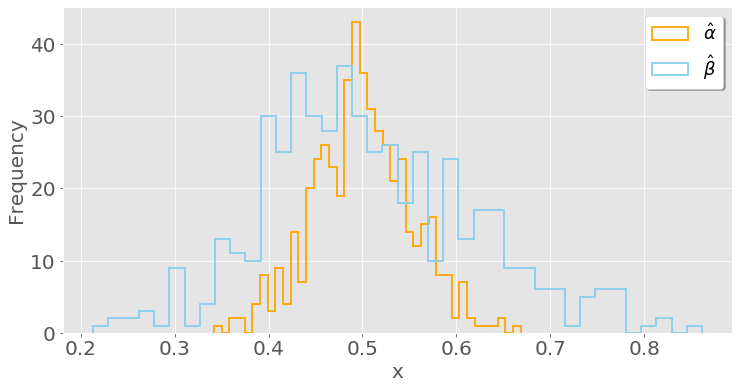

In [100]:
A_x, A_y, A_binwidth, fig, ax =  vis.nice_histogram(
    A_all, 40, show_plot=False, plot_legend=True, data_label_hist=r'$\hat\alpha$')
B_x, B_y, B_binwidth, fig, ax = vis.nice_histogram(
    B_all, 40, show_plot=False, plot_legend=True, data_label_hist=r'$\hat\beta$',
    axis = ax, figure = fig, color_hist= 'skyblue')
fig

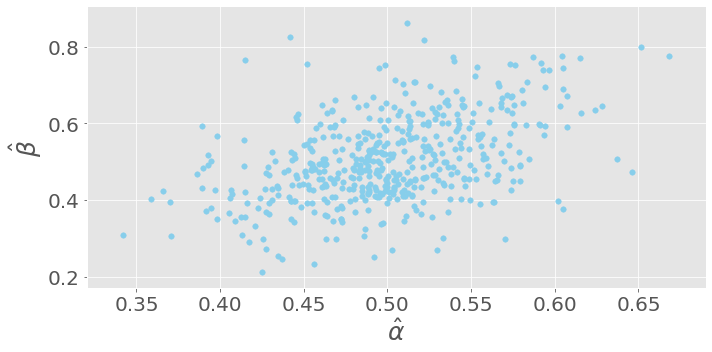

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcfcaf58ad0>,
 <Figure size 720x360 with 1 Axes>)

In [68]:
vis.nice_plot(A_all, B_all, scatter=True, xlabel=r'$\hat\alpha$',ylabel=r'$\hat\beta$' )

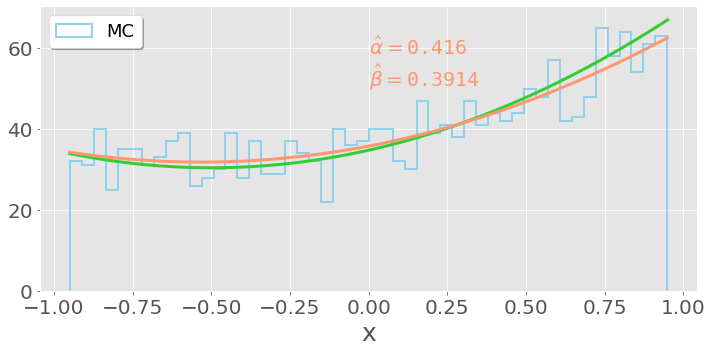

In [71]:
#show results
colors = vis.Color_palette(1)
n_bins = 50
binwidth = (xmax-xmin)/n_bins
yaxis = func_pdf(xaxis, alpha_real, beta_real)*binwidth*N_f

fig, ax = plt.subplots(figsize = (10,5))
_, _, _, fig, ax = vis.nice_histogram(
    x_rand, n_bins, axis = ax, figure = fig, show_plot = False, plot_errors=False, plot_hist=True, 
    data_label_hist = 'MC', plot_legend = True, color_hist = 'skyblue')
ax, fig = vis.nice_plot(
    xaxis, yaxis, axis = ax, figure = fig, show_plot=False,
    color = 'limegreen', data_label = r'$f(x, \alpha, \beta)\cdot binwidth \cdot N$')
ax, fig = vis.nice_plot(
        xaxis, func_pdf(xaxis, alpha_fit, beta_fit)*N_f*binwidth, axis = ax, figure = fig, 
        show_plot=False,color = colors[2], data_label = r'$f(x, \hat\alpha, \hat\beta)\cdot binwidth \cdot N$')
text = r'$\hat\alpha = $'+ '{:4.4}'.format(alpha_fit) + '\n' + r'$\hat\beta= $'+ '{:4.4}'.format(beta_fit)
ax.text(.5, .9, text, fontsize=20,  family='monospace', 
                    transform=ax.transAxes, color=colors[2], verticalalignment='top', horizontalalignment ='left')
fig

## 1b. Parametric Bootstrapping 

In [123]:
A_Integral = (100-68.27)/200*np.sum(A_y*A_binwidth)
A_left_bound = np.linspace(0.4, 0.49, 100)
A_int_left = np.empty(100)
for i in range(len(A_left_bound)):
    left_mask_A = A_x<A_left_bound[i]
    A_int_left[i] = np.sum(A_binwidth * A_y[left_mask_A])
    
A_right_bound = np.linspace(0.5, 0.6, 100)
A_int_right = np.empty(100)
for i in range(len(A_right_bound)):
    right_mask_A = A_x>A_right_bound[i]
    A_int_right[i] = np.sum(A_binwidth * A_y[right_mask_A])
A_left_bound[np.argmin(np.abs(A_int_left - A_Integral))], A_right_bound[np.argmin(np.abs(A_int_right - A_Integral))] 

(0.4445454545454546, 0.5505050505050505)

In [124]:
B_Integral = (100-68.27)/200*np.sum(B_y*B_binwidth)
B_left_bound = np.linspace(0.3, 0.45, 100)
B_int_left = np.empty(100)
for i in range(len(B_left_bound)):
    left_mask_B = B_x<B_left_bound[i]
    B_int_left[i] = np.sum(B_binwidth * B_y[left_mask_B])
    
B_right_bound = np.linspace(0.5, 0.65, 100)
B_int_right = np.empty(100)
for i in range(len(B_right_bound)):
    right_mask_B = B_x>B_right_bound[i]
    B_int_right[i] = np.sum(B_binwidth * B_y[right_mask_B])
B_left_bound[np.argmin(np.abs(B_int_left - B_Integral))], B_right_bound[np.argmin(np.abs(B_int_right - B_Integral))] 

(0.403030303030303, 0.5954545454545455)

###  Now fix alpha

In [126]:
num_MC = 500
B_all = np.empty(num_MC)
for i in range(num_MC):
    #generate points
    N_f = 2000
    x_rand = ast.accept_reject(func_pdf, N_f, xmin, xmax, ymax, random_state=i)
    #perform the fit using unbinned log likelihood
    ullh_f = UnbinnedLH(func_pdf, x_rand)
    f_minuit = Minuit(ullh_f, alpha = 0.5, pedantic=False, fix_alpha = True, print_level=0)
    f_minuit.migrad();       # This is where the minimisation is carried out!
    alpha_fit, beta_fit = f_minuit.args
    B_all[i] = beta_fit

In [127]:
np.median(B_all), np.std(B_all)

(0.5017463408090621, 0.09895532470821436)

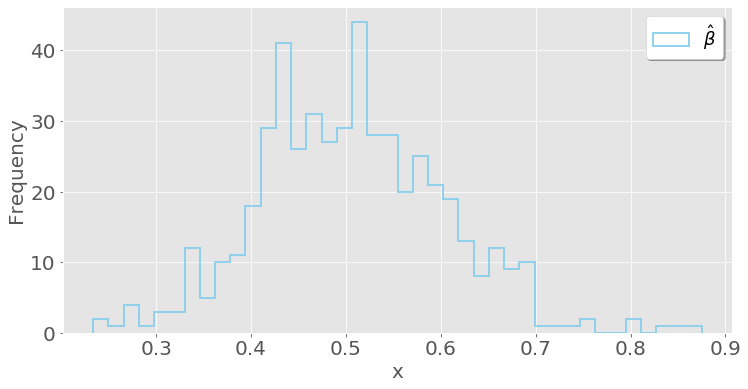

In [128]:
B_x, B_y, B_binwidth, fig, ax = vis.nice_histogram(
    B_all, 40, show_plot=False, plot_legend=True, data_label_hist=r'$\hat\beta$',
    color_hist= 'skyblue')
fig

In [129]:
B_Integral = (100-68.27)/200*np.sum(B_y*B_binwidth)
B_left_bound = np.linspace(0.3, 0.45, 100)
B_int_left = np.empty(100)
for i in range(len(B_left_bound)):
    left_mask_B = B_x<B_left_bound[i]
    B_int_left[i] = np.sum(B_binwidth * B_y[left_mask_B])
    
B_right_bound = np.linspace(0.5, 0.65, 100)
B_int_right = np.empty(100)
for i in range(len(B_right_bound)):
    right_mask_B = B_x>B_right_bound[i]
    B_int_right[i] = np.sum(B_binwidth * B_y[right_mask_B])
B_left_bound[np.argmin(np.abs(B_int_left - B_Integral))], B_right_bound[np.argmin(np.abs(B_int_right - B_Integral))] 

(0.403030303030303, 0.5954545454545455)

### Fix alpha but new range 

In [130]:
alpha_real, beta_real = .5, .5 
xmin, xmax = -.9, .85
def func_pdf(x, alpha = alpha_real, beta = beta_real): 
    return (1 + alpha*x + beta*x**2)/(xmax + 1/2*alpha*xmax**2 
                                      + 1/3*beta*xmax**3 
                                      - xmin - 1/2*alpha*xmin**2 
                                      - 1/3*beta*xmin**3)
ymax = func_pdf(xmax, alpha_real, beta_real)
xaxis = np.linspace(xmin,xmax,100)
yaxis = func_pdf(xaxis, alpha_real, beta_real)
ymax = func_pdf(xmax, alpha_real, beta_real) 

In [131]:
num_MC = 500
B_all = np.empty(num_MC)
for i in range(num_MC):
    #generate points
    N_f = 2000
    x_rand = ast.accept_reject(func_pdf, N_f, xmin, xmax, ymax, random_state=i)
    #perform the fit using unbinned log likelihood
    ullh_f = UnbinnedLH(func_pdf, x_rand)
    f_minuit = Minuit(ullh_f, alpha = 0.5, pedantic=False, fix_alpha = True, print_level=0)
    f_minuit.migrad();       # This is where the minimisation is carried out!
    alpha_fit, beta_fit = f_minuit.args
    B_all[i] = beta_fit

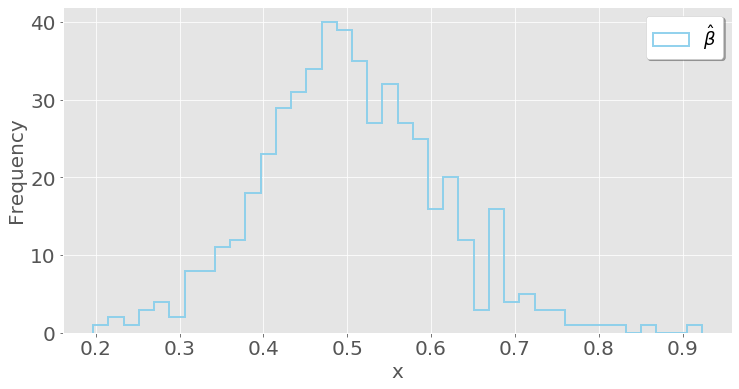

In [132]:
B_x, B_y, B_binwidth, fig, ax = vis.nice_histogram(
    B_all, 40, show_plot=False, plot_legend=True, data_label_hist=r'$\hat\beta$',
    color_hist= 'skyblue')
fig

In [133]:
B_Integral = (100-68.27)/200*np.sum(B_y*B_binwidth)
B_left_bound = np.linspace(0.3, 0.45, 100)
B_int_left = np.empty(100)
for i in range(len(B_left_bound)):
    left_mask_B = B_x<B_left_bound[i]
    B_int_left[i] = np.sum(B_binwidth * B_y[left_mask_B])
    
B_right_bound = np.linspace(0.5, 0.65, 100)
B_int_right = np.empty(100)
for i in range(len(B_right_bound)):
    right_mask_B = B_x>B_right_bound[i]
    B_int_right[i] = np.sum(B_binwidth * B_y[right_mask_B])
B_left_bound[np.argmin(np.abs(B_int_left - B_Integral))], B_right_bound[np.argmin(np.abs(B_int_right - B_Integral))] 

(0.3878787878787879, 0.6060606060606061)

## 1c 